In [1]:
# Importing Neccessary libiraries
import os, re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

## Data Preprocessing

In [2]:
# Data collection
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


In [3]:
# Data preparation
def read_file_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read().splitlines()

def preprocess_text_with_line_number(filename):
    """Parse SkimLit-style file into list of dicts:
       expects lines like: LABEL \t sentence
       abstracts separated by blank lines or '###' header lines.
    """
    lines = read_file_lines(filename)
    samples = []
    current_lines = []

    for raw in lines:
        if raw.strip().startswith("###") or raw.strip() == "":
            if current_lines:
                for i, line in enumerate(current_lines):
                    if "\t" not in line:
                        continue
                    label, text = line.split("\t", 1)
                    samples.append({
                        "target": label.strip(),
                        "text": text.strip().lower(),
                        "line_number": i,                       # 0-indexed
                        "total_lines": len(current_lines) - 1   # 0-indexed
                    })
                current_lines = []
            continue
        else:
            current_lines.append(raw)

    if current_lines:
        for i, line in enumerate(current_lines):
            if "\t" not in line:
                continue
            label, text = line.split("\t", 1)
            samples.append({
                "target": label.strip(),
                "text": text.strip().lower(),
                "line_number": i,
                "total_lines": len(current_lines) - 1
            })
    return samples

In [4]:
# Load Dataset
train_samples = preprocess_text_with_line_number(os.path.join(data_dir, "train.txt"))
val_samples   = preprocess_text_with_line_number(os.path.join(data_dir, "dev.txt"))
test_samples  = preprocess_text_with_line_number(os.path.join(data_dir, "test.txt"))

train_df = pd.DataFrame(train_samples)
val_df   = pd.DataFrame(val_samples)
test_df  = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [5]:
# Using OneHotEncoding
ohe = OneHotEncoder(sparse_output=False)
train_labels_one_hot = ohe.fit_transform(train_df[["target"]])
val_labels_one_hot   = ohe.transform(val_df[["target"]])
test_labels_one_hot  = ohe.transform(test_df[["target"]])
class_names = ohe.categories_[0]

In [6]:
# Text Vectorization
train_sentences = train_df.text.tolist()
val_sentences   = val_df.text.tolist()
test_sentences  = test_df.text.tolist()

sen_lens = [len(s.split()) for s in train_sentences]
output_seq_len = int(np.percentile(sen_lens, 95))

max_token = 68000
text_vectorizer = TextVectorization(max_tokens=max_token, output_sequence_length=output_seq_len)
text_vectorizer.adapt(train_sentences)
vocab = text_vectorizer.get_vocabulary()

token_embed = layers.Embedding(input_dim=len(vocab), output_dim=128, mask_zero=True, name="token_embedding")

In [7]:
# Model Creation
# Model inputs setup
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_inputs_embedding")
line_number_inputs = layers.Input(shape=(1,), dtype=tf.int32, name="line_number_inputs")
total_lines_inputs = layers.Input(shape=(1,), dtype=tf.int32, name="total_number_inputs")

# token/text branch
token_x = text_vectorizer(token_inputs)
token_x = token_embed(token_x)
token_x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_x)
token_x = layers.GlobalMaxPool1D()(token_x)
token_x = layers.Dense(128, activation="relu")(token_x)   # rich representation

# positional embedding
line_emb = layers.Embedding(input_dim=16, output_dim=32, mask_zero=False)(line_number_inputs)
line_emb = layers.Flatten()(line_emb)

total_emb = layers.Embedding(input_dim=21, output_dim=32, mask_zero=False)(total_lines_inputs)
total_emb = layers.Flatten()(total_emb)

# concating + output layer
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_emb, total_emb, token_x])
x = layers.Dense(128, activation="relu")(tribrid_embeddings)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

# Model
model = tf.keras.Model(inputs={"line_number_inputs": line_number_inputs,
                               "total_number_inputs": total_lines_inputs,
                               "token_inputs_embedding": token_inputs},
                       outputs=output_layer)

# Model compile
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()

# converting to integer arrays for positions
def clamp_arr(arr, max_allowed):
    a = np.array(arr, dtype=np.int32)
    a = np.clip(a, 0, max_allowed)
    return a.reshape(-1, 1)

train_line_idx  = clamp_arr(train_df.line_number.to_numpy(), 15)
val_line_idx    = clamp_arr(val_df.line_number.to_numpy(), 15)
test_line_idx   = clamp_arr(test_df.line_number.to_numpy(), 15)

train_total_idx = clamp_arr(train_df.total_lines.to_numpy(), 20)
val_total_idx   = clamp_arr(val_df.total_lines.to_numpy(), 20)
test_total_idx  = clamp_arr(test_df.total_lines.to_numpy(), 20)

# convert text lists to tf.constant dtype string
train_text_tf = tf.constant(train_sentences, dtype=tf.string)
val_text_tf   = tf.constant(val_sentences, dtype=tf.string)

# building dataset
train_ds = tf.data.Dataset.from_tensor_slices((
    {
        "line_number_inputs": train_line_idx,
        "total_number_inputs": train_total_idx,
        "token_inputs_embedding": train_text_tf
    },
    train_labels_one_hot
))

val_ds = tf.data.Dataset.from_tensor_slices((
    {
        "line_number_inputs": val_line_idx,
        "total_number_inputs": val_total_idx,
        "token_inputs_embedding": val_text_tf
    },
    val_labels_one_hot
))

train_ds = train_ds.shuffle(2000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# Callbacks creation
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_skimlit_model.h5", save_best_only=True, monitor="val_loss")
]

# Model Fit
model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_inputs_embed… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 55)        │          0 │ token_inputs_emb… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 55, 128)   │  8,299,648 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_inputs  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_number_inputs │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 55, 64)    │     41,024 │ token_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │        512 │ line_number_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │        672 │ total_number_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_positio… │ (None, 192)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     24,704 │ char_token_posit… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │        645 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,375,525 (31.95 MB)

 Trainable params: 8,375,525 (31.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8226 - loss: 0.7425

5627/5627 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - accuracy: 0.8226 - loss: 0.7425 - val_accuracy: 0.8878 - val_loss: 0.6162
Epoch 2/15
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 68s 12ms/step - accuracy: 0.9042 - loss: 0.5937 - val_accuracy: 0.8810 - val_loss: 0.6283
Epoch 3/15
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 66s 12ms/step - accuracy: 0.9388 - loss: 0.5348 - val_accuracy: 0.8756 - val_loss: 0.6479
Epoch 4/15
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - accuracy: 0.9643 - loss: 0.4870 - val_accuracy: 0.8716 - val_loss: 0.6697


In [8]:
# Prediction Function
def split_sentence(text):
    sents = [s.strip() for s in re.split(r'(?<!\d)\.\s+', text) if s.strip()]
    return sents

def preprocess_text(text):
    sents = split_sentence(text)
    total = max(0, len(sents) - 1)
    line_idxs = np.arange(len(sents), dtype=np.int32).reshape(-1, 1)
    total_idxs = np.full(shape=(len(sents), 1), fill_value=total, dtype=np.int32)
    tf_texts = tf.constant(sents, dtype=tf.string)

    ds = tf.data.Dataset.from_tensor_slices({
        "line_number_inputs": line_idxs,
        "total_number_inputs": total_idxs,
        "token_inputs_embedding": tf_texts
    }).batch(32)
    return ds, sents

def Skimlit(text):
    ds, sents = preprocess_text(text)
    preds = model.predict(ds)
    classes = np.argmax(preds, axis=1)
    labels = [class_names[c] for c in classes]
    return pd.DataFrame({"Sentence": sents, "Label": labels})

In [9]:
med_abs = """ Health is a fundamental pillar of human wellness, and the rapid advancements in large language models
(LLMs) have driven the development of a new generation of health agents. However, the application
of health agents to fulfill the diverse needs of individuals in daily health settings is underexplored.
In this work, we aim to build a comprehensive personal health agent that is able to reason about
multimodal personal health data from everyday consumer wellness devices and medical records and
provide personalized health recommendations. To understand end-users’ needs when interacting
with such an assistant, we conducted an in-depth analysis of web search and health forum queries,
alongside qualitative insights from users and health experts gathered through a user-centered design
process. Based on these findings, we identified three major skill categories to fulfill consumer health
needs, each of which is supported by a specialist sub-agent in our system: (1) a data science agent
that analyzes personal time-series wearable and medical record data, incorporating population-level
statistics to provide contextualized numerical health insights, (2) a health domain expert agent that
integrates users’ health and contextual data to generate accurate, personalized insights based on health
domain knowledge, and (3) a health coach agent that synthesizes data insights, drives multi-turn
user interactions and interactive goal setting, guiding users using a specified psychological strategy
and tracking users’ progress. Furthermore, we propose and develop Personal Health Agent (PHA), a
multi-agent framework that enables dynamic, personalized interactions to address individual health
needs. To evaluate each sub-agent and the multi-agent system, we conducted automated and human
evaluations across 10 benchmark tasks, involving more than 7,000 annotations and 1,100 hours of effort
from health experts and end-users. Our work represents the most comprehensive evaluation of a health
agent to date and establishes a strong foundation towards the futuristic vision of a personal health agent
accessible to everyone
"""
Skimlit(med_abs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


,Sentence,Label
0,Health is a fundamental pillar of human wellne...,BACKGROUND
1,"However, the application\nof health agents to ...",BACKGROUND
2,"In this work, we aim to build a comprehensive ...",BACKGROUND
3,To understand end-users’ needs when interactin...,METHODS
4,"Based on these findings, we identified three m...",RESULTS
5,"Furthermore, we propose and develop Personal H...",CONCLUSIONS
6,To evaluate each sub-agent and the multi-agent...,RESULTS
7,Our work represents the most comprehensive eva...,CONCLUSIONS


 41/942 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


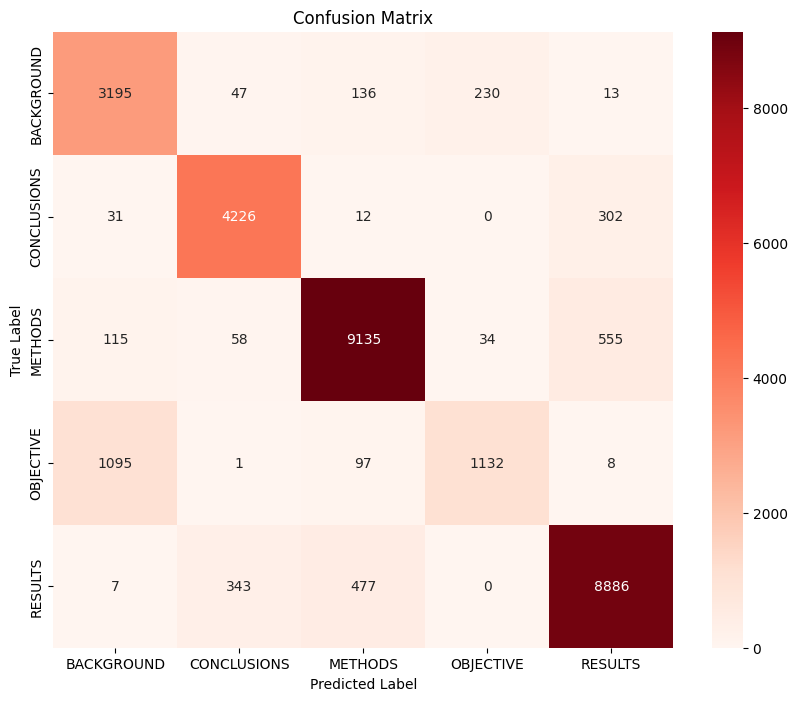

In [10]:
# Prepare test data for prediction
test_text_tf = tf.constant(test_sentences, dtype=tf.string)
test_ds = tf.data.Dataset.from_tensor_slices({
    "line_number_inputs": test_line_idx,
    "total_number_inputs": test_total_idx,
    "token_inputs_embedding": test_text_tf
}).batch(32)

# Make predictions
test_preds = model.predict(test_ds)
test_pred_classes = np.argmax(test_preds, axis=1)
test_true_labels = np.argmax(test_labels_one_hot, axis=1)

# Create confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
report = classification_report(test_true_labels, test_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

  BACKGROUND       0.72      0.88      0.79      3621
 CONCLUSIONS       0.90      0.92      0.91      4571
     METHODS       0.93      0.92      0.92      9897
   OBJECTIVE       0.81      0.49      0.61      2333
     RESULTS       0.91      0.91      0.91      9713

    accuracy                           0.88     30135
   macro avg       0.85      0.83      0.83     30135
weighted avg       0.88      0.88      0.88     30135

